# Figures

Random figures needed for other things

## Special Function Plots

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# L = np.pi
# h = 2

# x = np.linspace(-L, L, 1000)
# # f = lambda x: h * np.where((-L <= x) & (x <= -L/2), 0, np.where((-L/2 < x) & (x < L/2), 1, np.where((L/2 <= x) & (x <= L), 0, np.nan)))
# f = lambda x: h * np.where(x >= 0, 0, h)

# def partial_sum(x, n):
#     y = h / 2 * np.ones(x.shape)
#     # y += sum([2 * h / np.pi * (-1)**n / (2*n + 1) * np.cos((2*n + 1) * np.pi * x / L) for n in range(2*n + 1)])
#     y += sum([-2 * h / np.pi * np.sin(n * np.pi * x / L) / n for n in range(1, n+1, 2)])
#     return y

# plt.plot(x, f(x), alpha=1, linewidth=2, zorder=0, label='$f(x)$')
# plt.plot(x, partial_sum(x, 1), alpha=0.8, linewidth=1, zorder=1, label='$S_1$')
# plt.plot(x, partial_sum(x, 5), alpha=0.8, linewidth=1, zorder=2, label='$S_{5}$')
# plt.plot(x, partial_sum(x, 10), alpha=0.8, linewidth=1, zorder=3, label='$S_{10}$')
# plt.plot(x, partial_sum(x, 100), alpha=0.8, linewidth=1, zorder=4, label='$S_{100}$')
# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.xlim(-L, L)
# plt.ylim(-0.3, h * 1.2)
# plt.legend(loc='upper right')
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import scipy.special as sp
# from scipy.integrate import quad
# import math

# f = lambda x: np.where(x < 0, -1, np.where(x > 0, 1, np.nan))
# log_a = lambda n: mpmath.log(2*n + 1) + mpmath.log(mpmath.factorial(n-2)) - mpmath.log(2) * ((n + 1) // 2) - mpmath.log(mpmath.factorial((n-1)//2)) - mpmath.log(mpmath.factorial((n+1)//2))

# def legendre_coefficient(n):
#     integrand_left = lambda x: f(x) * sp.eval_legendre(n, x)
#     integral_left = quad(integrand_left, -1, 0, limit=100)[0]
#     integrand_right = lambda x: f(x) * sp.eval_legendre(n, x)
#     integral_right = quad(integrand_right, 0, 1, limit=100)[0]
#     return (2 * n + 1) / 2 * (integral_left + integral_right)

# def legendre_partial_sum(x, N):
#     y = np.zeros(x.shape)
#     for n in range(N + 1):
#         if n % 2 == 1:
#             an = legendre_coefficient(n)
#             y += an * sp.eval_legendre(n, x)
#     return y

# x = np.linspace(-1, 1, 1000)

# plt.plot(x, f(x), alpha=1, linewidth=2, zorder=0, label='$f(x)$')
# plt.plot(x, legendre_partial_sum(x, 3), alpha=0.8, linewidth=1, zorder=2, label='$S_{3}$')
# plt.plot(x, legendre_partial_sum(x, 5), alpha=0.8, linewidth=1, zorder=3, label='$S_{5}$')
# plt.plot(x, legendre_partial_sum(x, 7), alpha=0.8, linewidth=1, zorder=4, label='$S_{7}$')
# plt.plot(x, legendre_partial_sum(x, 99), alpha=0.8, linewidth=1, zorder=5, label='$S_{99}$')

# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.xlim(-1, 1)
# plt.ylim(-2, 2)
# plt.legend(loc='lower right')
# plt.show()

## Field Line Plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import *
from scipy.integrate import ode

class FieldLinePlotter:
    def __init__(self, distribution, n_field_lines=32, x_range=(-3, 3), y_range=(-3, 3), step_size=0.01, dt_factor=0.8):
        self.distribution = distribution
        self.n_field_lines = n_field_lines
        self.x_range = x_range
        self.y_range = y_range
        self.step_size = step_size
        self.dt_factor = dt_factor
        self._compute()

    @staticmethod
    def _field_dir(t, state, distribution):
        x, y = state
        field_x, field_y = distribution.field(x, y)
        field_norm = np.sqrt(field_x**2 + field_y**2)
        if field_norm < 1e-14:
            return [0, 0] # avoid division by zero
        return [field_x / field_norm, field_y / field_norm]

    def _compute_field_lines(self):
        x_lines, y_lines, directions = [], [], []
        seeds = self.distribution.seed_points(self.n_field_lines, self.step_size) 
        for (x_init, y_init) in seeds:
            for direction in [1, -1]:
                solver = ode(self._field_dir)
                solver.set_integrator('vode')
                solver.set_f_params(self.distribution)
                solver.set_initial_value([x_init, y_init], 0)      
                x_line = [x_init]
                y_line = [y_init]
                dt = direction * self.dt_factor * self.step_size
                while solver.successful():
                    x_prev, y_prev = solver.y.copy()
                    solver.integrate(solver.t + dt)
                    x_new, y_new = solver.y
                    x_line.append(x_new)
                    y_line.append(y_new)
                    if not (self.x_range[0] < x_new < self.x_range[1] and self.y_range[0] < y_new < self.y_range[1]):
                        break # break if outside drawing area
                    if np.hypot(x_new - x_prev, y_new - y_prev) < 1e-6:
                        break # break if steps aren't advancing
                x_lines.append(x_line)
                y_lines.append(y_line)
                directions.append(direction)
        self.x_lines = x_lines
        self.y_lines = y_lines
        self.directions = directions

    def _compute_potentials(self, grid_size=100):
        x_vals = np.linspace(self.x_range[0], self.x_range[1], grid_size)
        y_vals = np.linspace(self.y_range[0], self.y_range[1], grid_size)
        x_grid, y_grid = np.meshgrid(x_vals, y_vals)
        potentials = np.vectorize(lambda x, y: self.distribution.potential(x, y))(x_grid, y_grid)
        self.x_grid = x_grid
        self.y_grid = y_grid
        self.potentials = potentials

    def _compute(self):
        self._compute_field_lines()
        if hasattr(self.distribution, 'potential'):
            self._compute_potentials()

    def _calculate_field_line_arrows(self):
        arrow_data = []
        arrow_length = self.step_size * 5
        for i, (x_line, y_line, direction) in enumerate(zip(self.x_lines, self.y_lines, self.directions)):
            if len(x_line) > 5 and len(y_line) > 5 and i % (self.n_field_lines // 4) == 0:
                idx = len(x_line) // 2  # choose a point roughly in the middle
                if direction == 1:
                    dx = x_line[idx + 1] - x_line[idx]
                    dy = y_line[idx + 1] - y_line[idx]
                    norm = np.hypot(dx, dy)
                    if norm == 0:
                        continue
                    start = (x_line[idx], y_line[idx])
                    end   = (x_line[idx] + dx / norm * arrow_length, y_line[idx] + dy / norm * arrow_length)
                else:
                    dx = x_line[idx] - x_line[idx + 1]
                    dy = y_line[idx] - y_line[idx + 1]
                    norm = np.hypot(dx, dy)
                    if norm == 0:
                        continue
                    start = (x_line[idx + 1], y_line[idx + 1])
                    end   = (x_line[idx + 1] + dx / norm * arrow_length, y_line[idx + 1] + dy / norm * arrow_length)
                arrow_data.append({'start': start, 'end': end})
        return arrow_data

    def plot(self, plot_distribution=True, plot_field_lines=True, plot_equipotentials=False, n_equipotential_levels=10, line_width=0.5, 
             line_alpha=0.8, xlim=None, ylim=None, figsize=(6, 6), field_line_color='black', show_field_line_arrows=False,
             equipotential_color='green', axis='off', aspect='equal', title=None):
        xlim = xlim if xlim is not None else self.x_range
        ylim = ylim if ylim is not None else self.y_range
        plt.figure(figsize=figsize)
        ax = plt.gca()
        if plot_equipotentials and hasattr(self.distribution, 'potential'):
            ax.contour(self.x_grid, self.y_grid, self.potentials, levels=n_equipotential_levels, colors=equipotential_color, 
                       linewidths=line_width, alpha=line_alpha, zorder=1)
        if plot_field_lines:
            for x_line, y_line in zip(self.x_lines, self.y_lines):
                ax.plot(x_line, y_line, color=field_line_color, linewidth=line_width, alpha=line_alpha, zorder=2)
            if show_field_line_arrows:
                arrows = self._calculate_field_line_arrows()
                for arrow_info in arrows:
                    arrow = FancyArrowPatch(arrow_info['start'], arrow_info['end'], arrowstyle='-|>', mutation_scale=10, 
                                            color=field_line_color, zorder=2)
                    ax.add_patch(arrow)
        if plot_distribution:
            self.distribution.plot_distribution(ax, xlim=self.x_range, ylim=self.y_range)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.axis(axis)
        ax.set_aspect(aspect, adjustable='box')
        ax.set_title(title)
        plt.show()
        return ax

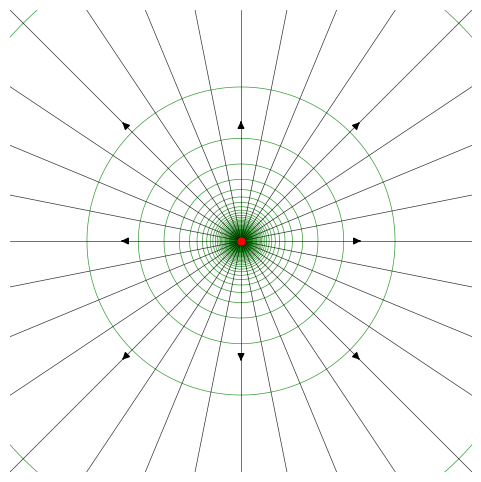

In [70]:
class PointCharge:
    def __init__(self, charge=1, position=(0, 0)):
        self.charge = charge
        self.x = position[0]
        self.y = position[1]

    def field(self, x, y):
        dx = x - self.x
        dy = y - self.y
        dr = np.sqrt(dx ** 2 + dy ** 2)
        if dr < 1e-6:
            return (0, 0) # avoid singularity at charge position
        return (self.charge * dx / dr ** 3, self.charge * dy / dr ** 3)

    def potential(self, x, y):
        dx = x - self.x
        dy = y - self.y
        dr = np.sqrt(dx**2 + dy**2)
        if dr < 1e-2:
            dr = 1e-2 # avoid singularity at charge position
        return self.charge / dr

    def seed_points(self, n_field_lines, step_size):
        angles = np.linspace(0, 2 * np.pi * (n_field_lines - 1) / n_field_lines, n_field_lines)
        seeds = []
        for angle in angles:
            x = self.x + np.cos(angle) * step_size
            y = self.y + np.sin(angle) * step_size
            seeds.append((x, y))
        return seeds

    def plot_distribution(self, ax, xlim, ylim):
        color = 'red' if self.charge > 0 else 'blue'
        ax.plot(self.x, self.y, 'o', color=color, ms=5, zorder=10)

class MultipleChargeDistributions:
    def __init__(self, distributions):
        self.distributions = distributions

    def field(self, x, y):
        total_field_x = sum([distribution.field(x, y)[0] for distribution in self.distributions])
        total_field_y = sum([distribution.field(x, y)[1] for distribution in self.distributions])
        return total_field_x, total_field_y

    def potential(self, x, y):
        return sum([distribution.potential(x, y) for distribution in self.distributions])

    def seed_points(self, n_field_lines, step_size):
        seeds = []
        for distribution in self.distributions:
            seeds.extend(distribution.seed_points(n_field_lines, step_size))
        return seeds

    def plot_distribution(self, ax, xlim, ylim):
        for distribution in self.distributions:
            distribution.plot_distribution(ax, xlim, ylim)

charges = [PointCharge(1, (0, 0))]
# charges = [PointCharge(-1, (0, -1)), PointCharge(1, (0, 1))]
# charges = [PointCharge(1, [1, 1]), PointCharge(-1, [1, -1]), PointCharge(1, [-1, -1]), PointCharge(-1, [-1, 1])]
distribution = MultipleChargeDistributions(charges)
plotter = FieldLinePlotter(distribution, n_field_lines=32, x_range=(-3, 3), y_range=(-3, 3))
plotter.plot(plot_equipotentials=True, n_equipotential_levels=100, show_field_line_arrows=True);

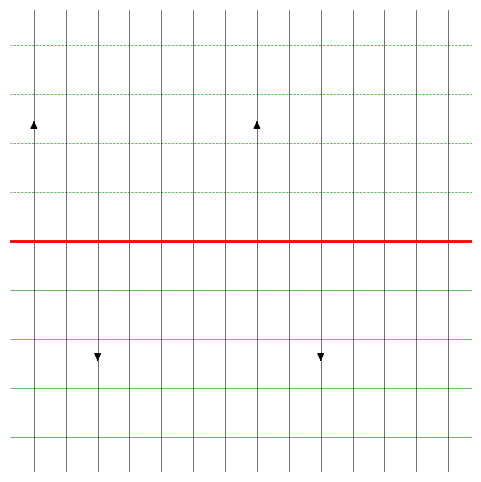

In [71]:
class InfiniteSheetDistribution:
    def __init__(self, sigma, center=(0, 0), normal_angle=90, span_length=3):
        self.sigma = sigma
        self.center = np.array(center, dtype=float)
        self.normal_angle = normal_angle
        self.normal = np.array([np.cos(self.normal_angle * np.pi / 180), np.sin(self.normal_angle * np.pi / 180)])
        self.tangent = np.array([-np.sin(self.normal_angle * np.pi / 180), np.cos(self.normal_angle * np.pi / 180)])
        self.span_length = span_length

    def field(self, x, y):
        dr = np.array([x, y], dtype=float) - self.center
        sign = 1 if np.dot(dr, self.normal) >= 0 else -1
        return sign * 4 * np.pi * self.sigma * self.normal

    def potential(self, x, y):
        dr = np.array([x, y], dtype=float) - self.center
        return -4 * np.pi * self.sigma * np.dot(dr, self.normal)

    def seed_points(self, n_field_lines, step_size):
        s_values = np.linspace(-self.span_length, self.span_length, n_field_lines)
        seeds_top = []
        seeds_bottom = []
        for s in s_values:
            base_point = self.center + s * self.tangent
            seeds_top.append(tuple(base_point + step_size * self.normal))
            seeds_bottom.append(tuple(base_point - step_size * self.normal))
        return seeds_top + seeds_bottom

    def plot_distribution(self, ax, xlim, ylim):
        color = 'red' if self.sigma > 0 else 'blue'
        L = max(xlim[1] - xlim[0], ylim[1] - ylim[0]) * 2
        p1 = self.center - (L / 2) * self.tangent
        p2 = self.center + (L / 2) * self.tangent
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], '-', color=color, linewidth=2, zorder=10)

class HollowSphereDistribution:
    def __init__(self, sigma=1, charge=None, radius=1, center=(0, 0)):
        self.sigma = sigma
        self.radius = radius
        self.center = center
        self.charge = charge if charge is not None else 4 * np.pi * self.sigma * self.radius ** 2

    def field(self, x, y):
        dx = x - self.center[0]
        dy = y - self.center[1]
        dr = np.sqrt(dx ** 2 + dy ** 2)
        if dr < self.radius:
            return (0, 0)
        else:
            return (self.charge * dx / dr ** 3, self.charge * dy / dr ** 3)

    def potential(self, x, y):
        dx = x - self.center[0]
        dy = y - self.center[1]
        dr = np.sqrt(dx ** 2 + dy ** 2)
        if dr < self.radius:
            return self.charge / self.radius
        else:
            return self.charge / dr

    def seed_points(self, n_field_lines, step_size):
        angles = np.linspace(0, 2 * np.pi, n_field_lines, endpoint=False)
        seeds_outside = [((self.radius + step_size) * np.cos(angle) + self.center[0], 
                          (self.radius + step_size) * np.sin(angle) + self.center[1]) for angle in angles]
        seeds_inside  = [((self.radius - step_size) * np.cos(angle) + self.center[0], 
                          (self.radius - step_size) * np.sin(angle) + self.center[1]) for angle in angles]
        return seeds_outside + seeds_inside

    def plot_distribution(self, ax, xlim, ylim):
        color = 'red' if self.charge > 0 else 'blue'
        circle = plt.Circle(self.center, self.radius, edgecolor=color, facecolor='none', linewidth=2, zorder=10)
        ax.add_patch(circle)

class SolidSphereDistribution:
    def __init__(self, rho=1, charge=None, radius=1, center=(0, 0)):
        self.rho = rho
        self.radius = radius
        self.center = center
        self.charge = charge if charge is not None else self.charge_enclosed(self.radius)

    def charge_enclosed(self, r):
        return 4 / 3 * np.pi * self.rho * r ** 3

    def field(self, x, y):
        dx = x - self.center[0]
        dy = y - self.center[1]
        dr = np.sqrt(dx ** 2 + dy ** 2)
        if dr < 1e-6:
            dr = 1e-6 # avoid singularity near the center
        charge = self.charge_enclosed(dr) if dr < self.radius else self.charge
        return (charge * dx / dr ** 3, charge * dy / dr ** 3)

    def potential(self, x, y):
        dx = x - self.center[0]
        dy = y - self.center[1]
        dr = np.sqrt(dx ** 2 + dy ** 2)
        if dr < 1e-6:
            dr = 1e-6 # avoid singularity near the center
        charge = self.charge_enclosed(dr) if dr < self.radius else self.charge_enclosed(self.radius)
        return charge / dr

    def seed_points(self, n_field_lines, step_size):
        angles = np.linspace(0, 2 * np.pi, n_field_lines, endpoint=False)
        seeds_outside = [((self.radius + step_size) * np.cos(angle) + self.center[0], 
                          (self.radius + step_size) * np.sin(angle) + self.center[1]) for angle in angles]
        seeds_inside  = [((self.radius - step_size) * np.cos(angle) + self.center[0], 
                          (self.radius - step_size) * np.sin(angle) + self.center[1]) for angle in angles]
        return seeds_outside + seeds_inside

    def plot_distribution(self, ax, xlim, ylim):
        color = 'red' if self.charge > 0 else 'blue'
        circle = plt.Circle(self.center, self.radius, edgecolor=color, facecolor='gray', linewidth=2, zorder=10, alpha=0.5)
        ax.add_patch(circle)

# # Infinite sheet of charge
sheet = InfiniteSheetDistribution(sigma=1, center=(0, 0), normal_angle=90, span_length=6)
plotter = FieldLinePlotter(sheet, n_field_lines=30, x_range=(-3, 3), y_range=(-3, 3))
plotter.plot(plot_equipotentials=True, show_field_line_arrows=True);

# # Hollow sphere of charge
# hollow_sphere = HollowSphereDistribution(sigma=1, radius=1, center=(0, 0))
# plotter = FieldLinePlotter(hollow_sphere, n_field_lines=30, x_range=(-3, 3), y_range=(-3, 3))
# plotter.plot(plot_equipotentials=True, show_field_line_arrows=True);

# Solid sphere of charge
# solid_sphere = SolidSphereDistribution(rho=1, radius=1, center=(0, 0))
# plotter = FieldLinePlotter(solid_sphere, n_field_lines=30, x_range=(-3, 3), y_range=(-3, 3))
# plotter.plot(plot_equipotentials=True, show_field_line_arrows=True);

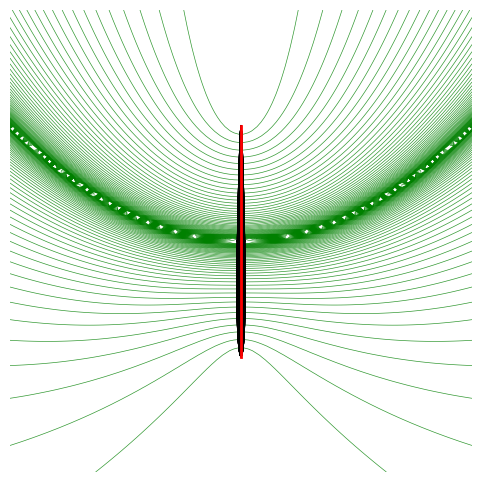

<Axes: >

In [14]:
# class FiniteWireDistribution:
#     def __init__(self, lam, L, center=(0,0), seed_radius=0.1):
#         self.lam = lam
#         self.L = L
#         self.center = np.array(center, dtype=float)
#         self.seed_radius = seed_radius

#     def potential(self, x, y):
#         """
#         Potential at (x,y) in the plane z=0, for a wire of length L centered at z=0.
#         Formula (in suitable units):
#           phi(rho) = lam * ln( [sqrt(rho^2 + (L/2)^2) + L/2] / [sqrt(rho^2 + (L/2)^2) - L/2] )
#         """
#         dx = x - self.center[0]
#         dy = y - self.center[1]
#         rho = np.sqrt(dx*dx + dy*dy)
#         # Avoid any singularity exactly at rho=0:
#         if rho < 1e-14:
#             rho = 1e-14
#         halfL = self.L / 2
#         term = np.sqrt(rho*rho + halfL*halfL)
#         # Log(...) must remain positive; for large rho, it is > 1, so no issue
#         return self.lam * np.log((term + halfL)/(term - halfL))

#     def field(self, x, y):
#         """
#         E = - grad(phi). In cylindrical coords:
#           E_rho = - d(phi)/d(rho),  E_phi = 0.
#         Then we project E_rho onto (x,y) using (x/rho, y/rho).
#         """
#         dx = x - self.center[0]
#         dy = y - self.center[1]
#         rho = np.sqrt(dx*dx + dy*dy)
#         if rho < 1e-14:
#             return (0, 0)

#         halfL = self.L / 2
#         term = np.sqrt(rho*rho + halfL*halfL)
#         # Potential phi(rho) = lam * ln( (term + halfL)/(term - halfL) ).
#         # d(phi)/d(rho) = lam * [ d/d(rho) of ln(...) ].
#         # Derivative of ln( (A+B)/(A-B) ) wrt A is 2B/(A^2 - B^2).
#         # Here A=term, B=halfL, term = sqrt(rho^2 + halfL^2).
#         # So d(term)/d(rho) = rho / term.
#         # So d(phi)/d(rho) = lam * [ 2 * halfL / ( (term)^2 - (halfL)^2 ) ] * d(term)/d(rho).
#         # => d(phi)/d(rho) = lam * [ 2 * halfL / ( term^2 - halfL^2 ) ] * ( rho / term ).
#         # But term^2 - halfL^2 = rho^2, so that factor simplifies nicely:
#         # => d(phi)/d(rho) = lam * [ 2 * halfL / rho^2 ] * ( rho / term ) = lam * [ 2 * halfL * rho / ( rho^2 * term ) ].
#         # => = lam * [ 2 * halfL / ( rho * term ) ].
#         dphi_drho = self.lam * (2 * halfL)/(rho * term)

#         # E_rho = - d(phi)/d(rho).
#         E_rho = -dphi_drho
#         # Convert to cartesian:
#         Ex = E_rho * (dx / rho)
#         Ey = E_rho * (dy / rho)
#         return (Ex, Ey)

#     def seed_points(self, n_lines, step_size):
#         """
#         Generate seed points around the wire in a small circle of radius self.seed_radius.
#         """
#         seeds = []
#         angles = np.linspace(0, 2*np.pi, n_lines, endpoint=False)
#         for alpha in angles:
#             x0 = self.center[0] + self.seed_radius*np.cos(alpha)
#             y0 = self.center[1] + self.seed_radius*np.sin(alpha)
#             seeds.append((x0, y0))
#         return seeds

#     def plot_distribution(self, ax, xlim, ylim):
#         """
#         In a pure 2D cross-section, the wire is a line along z. We can just draw a dot or small circle
#         at the 'center' for reference. Or do nothing if you prefer.
#         """
#         # Let's draw a small circle at the center to represent the wire's cross-section.
#         wire_circle = plt.Circle(self.center, 0.03*self.L, edgecolor='red', facecolor='red', zorder=10)
#         ax.add_patch(wire_circle)

# class FiniteWireDistribution:
#     def __init__(self, lam, L, center=(0, 0), seed_radius=0.05):
#         """
#         Represents a finite wire (line charge) of length L oriented vertically along the z-axis,
#         as seen in the yz-plane. The wire is centered at 'center' (y,z).
#         """
#         self.lam = lam
#         self.L = L
#         self.center = np.array(center, dtype=float)
#         self.seed_radius = seed_radius

#     def potential(self, y, z):
#         """
#         Returns the scalar potential at the point (y,z) in the yz-plane.
#         We use the closed-form expression with an absolute value so that the argument
#         of the logarithm is always positive. A small epsilon is added to avoid division
#         by zero.
#         """
#         halfL = self.L / 2.0
#         # Shift coordinates relative to the wire's center if desired.
#         # Here we assume the wire is centered at z=center[1] and y=center[0].
#         # For simplicity, assume center is (0,0); if not, you can shift (y,z) accordingly.
#         # In a more complete implementation, you'd use:
#         #   y_eff = y - self.center[0]
#         #   z_eff = z - self.center[1]
#         # Here I'll assume center is (0,0) for clarity.
#         num = np.sqrt(y**2 + (z + halfL)**2) - (z - halfL)
#         den = np.sqrt(y**2 + (z - halfL)**2) - (z + halfL)
#         eps = 1e-12
#         ratio = np.abs((num + eps) / (den + eps))
#         return self.lam * np.log(ratio)

#     def field(self, y, z):
#         """
#         Compute the electric field as the negative gradient of the potential.
#         Here we use a central difference approximation.
#         """
#         h = 1e-5
#         dphi_dy = (self.potential(y + h, z) - self.potential(y - h, z)) / (2 * h)
#         dphi_dz = (self.potential(y, z + h) - self.potential(y, z - h)) / (2 * h)
#         return (-dphi_dy, -dphi_dz)

#     def seed_points(self, n_lines, step_size):
#         """
#         Generate seed points for field-line integration by placing n_lines evenly 
#         around a small circle of radius seed_radius centered at self.center.
#         """
#         seeds = []
#         angles = np.linspace(0, 2 * np.pi, n_lines, endpoint=False)
#         for alpha in angles:
#             y0 = self.center[0] + self.seed_radius * np.cos(alpha)
#             z0 = self.center[1] + self.seed_radius * np.sin(alpha)
#             seeds.append((y0, z0))
#         return seeds

#     def plot_distribution(self, ax, xlim, ylim):
#         """
#         Plot the wire as a vertical line at y = center[0] from z = center[1]-L/2 to z = center[1]+L/2.
#         """
#         y0 = self.center[0]
#         z_low = self.center[1] - self.L/2.0
#         z_high = self.center[1] + self.L/2.0
#         ax.plot([y0, y0], [z_low, z_high], '-', color='red', linewidth=2)

# distribution = FiniteWireDistribution(lam=10, L=3)
# plotter = FieldLinePlotter(distribution, n_field_lines=300, x_range=(-3, 3), y_range=(-3, 3))
# plotter.plot(plot_equipotentials=True, n_equipotential_levels=100)

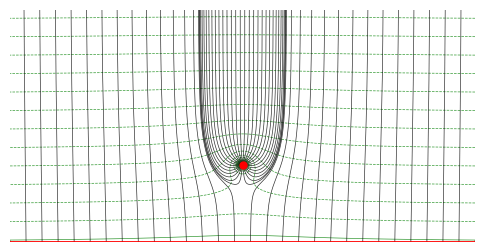

In [17]:
# handle boundary conditions by having DirichletBoundaryCondition and NeumannBoundaryCondition classes similar to distributions
# would need to think through how to ensure field lines and potentials satisfy imposed boundary conditions

charge = PointCharge(charge=1, position=(0, 1))
sheet = InfiniteSheetDistribution(sigma=1)
distribution = MultipleChargeDistributions([charge, sheet])

# charge = PointCharge(charge=1, position=(2, 2))
# sphere = HollowSphereDistribution(sigma=1, radius=1, center=(0, 0))
# sheet = InfiniteSheetDistribution(sigma=1, center=(-2, -2), normal_angle=45)
# distribution = MultipleChargeDistributions([charge, sphere, sheet])

plotter = FieldLinePlotter(distribution, n_field_lines=30, x_range=(-3, 3), y_range=(0, 3))
plotter.plot(plot_equipotentials=True, n_equipotential_levels=20);

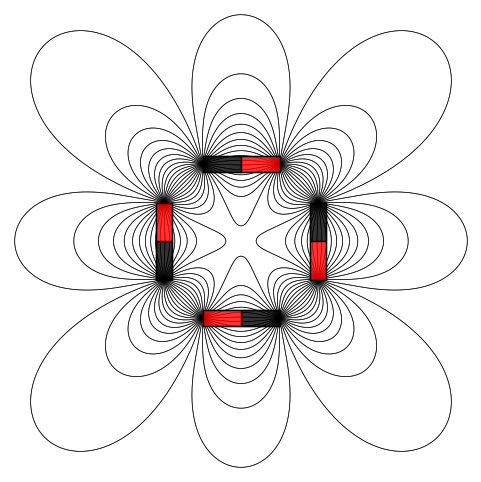

In [18]:
class MagneticDipole:
    def __init__(self, m, center, angle, length, width=0.4):
        self.m = m
        self.center = np.array(center, dtype=float)
        self.angle = angle * np.pi / 180
        self.length = length
        self.width = width
        self.u = np.array([np.cos(self.angle), np.sin(self.angle)])
        self.v = np.array([-np.sin(self.angle), np.cos(self.angle)])
        self.north_position = self.center + (self.length / 2) * self.u
        self.south_position = self.center - (self.length / 2) * self.u

class MagneticDipoleDistribution:
    def __init__(self, dipoles):
        self.dipoles = dipoles

    def field(self, x, y):
        # each dipole is modeled as two monopoles, one at the north pole (+m) and one at the south pole (-m).
        Bx, By = 0, 0
        point = np.array([x, y], dtype=float)
        for dipole in self.dipoles:
            # north pole
            r_north = point - dipole.north_position
            r2_north = np.dot(r_north, r_north)
            if r2_north > 1e-12:
                r3_north = r2_north ** 1.5
                Bx += dipole.m * r_north[0] / r3_north
                By += dipole.m * r_north[1] / r3_north
            # south pole
            r_south = point - dipole.south_position
            r2_south = np.dot(r_south, r_south)
            if r2_south > 1e-12:
                r3_south = r2_south ** 1.5
                Bx += -dipole.m * r_south[0] / r3_south
                By += -dipole.m * r_south[1] / r3_south
        return Bx, By

    def seed_points(self, n_field_lines, step_size):
        seeds = []
        angles = np.linspace(0, 2 * np.pi * (n_field_lines - 1) / n_field_lines, n_field_lines)
        for dipole in self.dipoles:
            for pole in [dipole.north_position, dipole.south_position]:
                for angle in angles:
                    x0 = pole[0] + np.cos(angle) * step_size
                    y0 = pole[1] + np.sin(angle) * step_size
                    seeds.append((x0, y0))
        return seeds

    def plot_distribution(self, ax, xlim, ylim):
        for dipole in self.dipoles:
            # u is the unit vector along the dipole axis and v is perpendicular
            half_length = dipole.length / 2
            half_width = dipole.width / 2
            center = dipole.center
            # northern half: from center to center + half_length * u
            north_corners = [center - half_width * dipole.v, center + half_width * dipole.v, 
                             center + half_width * dipole.v + half_length * dipole.u, center - half_width * dipole.v + half_length * dipole.u]
            north_poly = Polygon(north_corners, closed=True, facecolor='red', edgecolor='red', alpha=0.8, zorder=10)
            # southern half: from center to center - half_length * u
            south_corners = [center - half_width * dipole.v, center + half_width * dipole.v, 
                             center + half_width * dipole.v - half_length * dipole.u, center - half_width * dipole.v - half_length * dipole.u]
            south_poly = Polygon(south_corners, closed=True, facecolor='black', edgecolor='black', alpha=0.8, zorder=10)
            ax.add_patch(north_poly)
            ax.add_patch(south_poly)
            # draw an outline for the entire dipole
            full_corners = [center - half_width * dipole.v - half_length * dipole.u, center + half_width * dipole.v - half_length * dipole.u, 
                            center + half_width * dipole.v + half_length * dipole.u, center - half_width * dipole.v + half_length * dipole.u]
            outline = Polygon(full_corners, closed=True, fill=False, edgecolor='black', linewidth=1, zorder=11)
            ax.add_patch(outline)

distribution = MagneticDipoleDistribution([
    MagneticDipole(m=1, center=[0, 1], angle=0, length=1.0, width=0.2),
    MagneticDipole(m=1, center=[1, 0], angle=-90, length=1.0, width=0.2),
    MagneticDipole(m=1, center=[0, -1], angle=180, length=1.0, width=0.2),
    MagneticDipole(m=1, center=[-1, 0], angle=90, length=1.0, width=0.2)
])
plotter = FieldLinePlotter(distribution, n_field_lines=40, x_range=(-3, 3), y_range=(-3, 3))
plotter.plot();

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.integrate import ode as ode
# from matplotlib import cm
# from tqdm.notebook import tqdm
# # from itertools import product

# class charge:
#     def __init__(self, q, pos):
#         self.q=q
#         self.pos=pos
 
# def E_point_charge(q, a, x, y):
#     return q*(x-a[0])/((x-a[0])**2+(y-a[1])**2)**(1.5), \
#         q*(y-a[1])/((x-a[0])**2+(y-a[1])**2)**(1.5)
 
# def E_total(x, y, charges):
#     Ex, Ey=0, 0
#     for C in charges:
#         E=E_point_charge(C.q, C.pos, x, y)
#         Ex=Ex+E[0]
#         Ey=Ey+E[1]
#     return [ Ex, Ey ]

# def E_dir(t, y, charges):
#     Ex, Ey=E_total(y[0], y[1], charges)
#     n=np.sqrt(Ex**2+Ey*Ey)
#     return [Ex/n, Ey/n]

# # # charges and positions
# n_lines = 32 # 2 * 2048
# # charges = [charge(1, [0, 0])]
# # charges = [charge(1, [0, -d]), charge(1, [0, d])]
# charges = [charge(-1, [0, -1]), charge(1, [0, 1])]
# # charges = [charge(-1, [0, -d]), charge(4, [0, d])]
# # charges = [charge(1, [1, 1]), charge(-1, [1, -1]), charge(1, [-1, -1]), charge(-1, [-1, 1])]
# # charges = [charge(1, [1, 1]), charge(1, [1, -1]), charge(1, [-1, -1]), charge(1, [-1, 1]),
# #            charge(-1, [0, d]), charge(-1, [-1, 0]), charge(-1, [0, -1]), charge(-1, [1, 0])]
# # charges = []
# # for x in np.linspace(-1.5, 1.5, 50):
# #     for y in np.linspace(-1.5, 1.5, 50):
# #         if x**2 + y**2 <= 1.5**2:
# #             charges.append(charge(1, [x, y]))

# # calculate field lines
# x0, x1=-3, 3
# y0, y1=-3, 3
# R=0.01
# # loop over all charges
# xs,ys = [],[]
# for C in tqdm(charges, leave=False):
#     # plot field lines starting in current charge
#     dt=0.8*R
#     if C.q<0:
#         dt=-dt
#     # loop over field lines starting in different directions 
#     # around current charge
#     for alpha in np.linspace(0, 2*np.pi*(n_lines-1)/n_lines, n_lines):
#         r=ode(E_dir)
#         r.set_integrator('vode')
#         r.set_f_params(charges)
#         x=[ C.pos[0] + np.cos(alpha)*R ]
#         y=[ C.pos[1] + np.sin(alpha)*R ]
#         r.set_initial_value([x[0], y[0]], 0)
#         while r.successful():
#             r.integrate(r.t+dt)
#             x.append(r.y[0])
#             y.append(r.y[1])
#             hit_charge=False
#             # check if field line left drwaing area or ends in some charge
#             for C2 in charges:
#                 if np.sqrt((r.y[0]-C2.pos[0])**2+(r.y[1]-C2.pos[1])**2)<R:
#                     hit_charge=True
#             if hit_charge or (not (x0<r.y[0] and r.y[0]<x1)) or \
#                     (not (y0<r.y[1] and r.y[1]<y1)):
#                 break
#         xs.append(x)
#         ys.append(y)

# plt.figure(figsize=(5.5, 4.5),facecolor="w")

# # plot field line
# for x, y in zip(xs,ys):
#     plt.plot(x, y, color="black", linewidth=0.5, alpha=0.8)

# # plot point charges
# for C in charges:
#     if C.q>0:
#         # plt.plot(C.pos[0], C.pos[1], 'wo', ms=70, markeredgecolor='k')
#         plt.plot(C.pos[0], C.pos[1], 'ro', ms=5) #*np.sqrt(C.q))
#     if C.q<0:
#         plt.plot(C.pos[0], C.pos[1], 'ko', ms=5) #*np.sqrt(-C.q))

# plt.xlim(x0, x1)
# plt.ylim(y0, y1)
# plt.axis('off')
# plt.axis('equal')
# plt.show()

# calculate and plot the electric potential

# def V_point_charge(q, a, x, y):
#     return q/((x-a[0])**2+(y-a[1])**2)**(0.5)

# def V_total(x, y, charges):
#     V=0
#     for C in charges:
#         Vp=V_point_charge(C.q, C.pos, x, y)
#         V = V+Vp
#     return V

# vvs = []
# xxs = []
# yys = []
# numcalcv = 300
# for xx,yy in product(np.linspace(x0,x1,numcalcv),np.linspace(y0,y1,numcalcv)):
#     xxs.append(xx)
#     yys.append(yy)
#     vvs.append(V_total(xx,yy,charges))
# xxs = np.array(xxs)
# yys = np.array(yys)
# vvs = np.array(vvs)

# clim0,clim1 = -2,2
# vvs[np.where(vvs<clim0)] = clim0*0.999999 # to avoid error
# vvs[np.where(vvs>clim1)] = clim1*0.999999 # to avoid error
# plt.tricontour(xxs,yys,vvs,10,colors="0.3")
# plt.tricontourf(xxs,yys,vvs,100,cmap=cm.jet)
# cbar = plt.colorbar()
# cbar.set_clim(clim0,clim1)
# cbar.set_ticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2])
# cbar.set_label("Electric Potential")
# plt.xlabel('$x$')
# plt.ylabel('$y$')
# plt.xlim(x0, x1)
# plt.ylim(y0, y1)
# plt.axes().set_aspect('equal','datalim')
# plt.savefig('electric_force_lines_1.png',dpi=250,bbox_inches="tight",pad_inches=0.02)
# plt.show()

## Other

In [ ]:
# ! llm 'Write a simple python hello world function'

In [1]:
# %load_ext jupyter_tikz

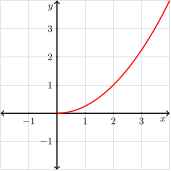

In [48]:
# %%tikz

# \begin{tikzpicture}
#     \draw[gray,very thin] (-2,-2) grid (4,4);
#     \draw[very thick,<->] (-2,0) -- (4,0) node[anchor=north east] {$x$};
#     \draw[very thick,<->] (0,-2) -- (0,4) node[anchor=north east] {$y$};
#     \foreach \x in {-1,1,2,3}
#        \draw (\x cm,1pt) -- (\x cm,-1pt) node[anchor=north] {$\x$};
#     \foreach \y in {-1,1,2,3}
#         \draw (1pt,\y cm) -- (-1pt,\y cm) node[anchor=east] {$\y$};
#     \draw[very thick,red] (0,0) parabola (4,4);
#     % \fill[white!40!blue] (0,0) parabola (4,4);
# \end{tikzpicture}

In [75]:
# %%tikz -as=full-document

# \documentclass{article}
# \usepackage[siunitx]{circuitikz}

# \begin{document}

# \begin{circuitikz} 
#     \draw 
#         (0,0) to[battery, l=V, i=I] (0,4)
#         to[R, l=R] (4,4)
#         to[L, l=L] (4,0) -- (3.5,0)
#         to[C, l=C] (0.5,0) -- (0,0)
#         % to[lamp, *-*] (0.5,0) -- (0,0)
#         % (0.5,0) -- (0.5,-2)
#         % to[voltmeter] (3.5,-2) -- (3.5,0)
#     ;
# \end{circuitikz}

# \end{document}

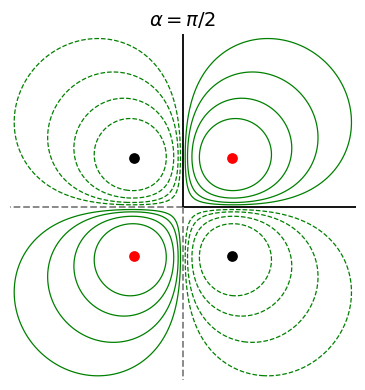

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import math

def image_charges(alpha_rad, d=1.0, q=1.0):
    n = int(round(math.pi / alpha_rad))          # α = π / n
    P0 = np.array([d * math.cos(alpha_rad / 2),
                   d * math.sin(alpha_rad / 2)]) # real charge
    # reflections:  y → -y  and  reflection in line making angle α
    R_y0 = np.array([[1, 0], [0, -1]])
    n2   = np.array([-math.sin(alpha_rad), math.cos(alpha_rad)])
    R_line = np.eye(2) - 2 * np.outer(n2, n2) / np.dot(n2, n2)
    ROT = R_line @ R_y0                           # rotation by 2α
    charges = []
    for k in range(n):
        Pk = np.linalg.matrix_power(ROT, k) @ P0  # rotation (even)
        charges.append((+q, *Pk))
        charges.append((-q, *(R_y0 @ Pk)))        # reflect partner (odd)
    return charges

def plot_wedge(ax, alpha_rad, title_tex, d=1.0, window=3.0, grid_pts=801, contour_base=(1, 0.5, 0.25, 0.125)):
    charges = image_charges(alpha_rad, d=d)
    # grid
    x = np.linspace(-window, window, grid_pts)
    X, Y = np.meshgrid(x, x)
    Phi  = np.zeros_like(X)
    for q_i, x_i, y_i in charges:
        Phi += q_i / np.hypot(X - x_i, Y - y_i)
    # mask near singularities
    mask = np.zeros_like(Phi, dtype=bool)
    for _, x_i, y_i in charges:
        mask |= np.hypot(X - x_i, Y - y_i) < 0.10
    Phi = np.ma.array(Phi, mask=mask)
    # contour levels (dipole-like geometric series)
    base = np.array(contour_base)
    pos_levels = np.sort(base)
    neg_levels = -np.sort(base)[::-1]
    ax.contour(X, Y, Phi, levels=pos_levels,  colors='green', linewidths=0.9)
    ax.contour(X, Y, Phi, levels=neg_levels, colors='green', linewidths=0.9, linestyles='dashed')
    # draw conductor planes
    t = np.linspace(0, window, 2)
    ax.plot(t, np.zeros_like(t), color='black', lw=1.3, linestyle='-')          # y = 0
    ax.plot(-t, np.zeros_like(t), color='gray', lw=1.3, linestyle='--')
    if not math.isclose(alpha_rad, math.pi):           # need second plane
        if math.isclose(alpha_rad, math.pi/2) or math.isclose(alpha_rad, math.pi/4):
            ax.plot(np.zeros_like(t), t, color='black', lw=1.3, linestyle='-')  # x = 0
            ax.plot(np.zeros_like(t), -t, color='gray', lw=1.3, linestyle='--')
        if math.isclose(alpha_rad, math.pi/4) or math.isclose(alpha_rad, math.pi/3):
            ax.plot(t, math.tan(alpha_rad) * t, color='black', lw=1.3, linestyle='-')  # generic line
            ax.plot(-t, math.tan(alpha_rad) * t, color='gray', lw=1.3, linestyle='--')
            ax.plot(-t, -math.tan(alpha_rad) * t, color='gray', lw=1.3, linestyle='--')
            ax.plot(t, -math.tan(alpha_rad) * t, color='gray', lw=1.3, linestyle='--')
    # plot charges
    for q_i, x_i, y_i in charges:
        ax.scatter(x_i, y_i, s=45, marker='o', color=('red' if q_i > 0 else 'black'), zorder=3)

    ax.set_xlim(-window, window)
    ax.set_ylim(-window, window)
    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_title(title_tex, pad=6, fontsize=14)

# fig, axes = plt.subplots(1, 2, figsize=(8, 8))
angle_list = [math.pi/2] # [math.pi/4, math.pi/3] # [math.pi, math.pi/2, math.pi/3, math.pi/4]  # radians
title_list = [r"$\alpha=\pi/2$"] # [r"$\alpha=\pi/4$", r"$\alpha=\pi/3$"] # [r"$\alpha=\pi$", r"$\alpha=\pi/2$", r"$\alpha=\pi/3$", r"$\alpha=\pi/4$"]
# for ax, alpha, title in zip(axes.flat, angle_list, title_list):
#     plot_wedge(ax, alpha, title, window=2.5)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_wedge(ax, alpha, title, window=2.5)
plt.tight_layout()
plt.show()